In [1]:
import sys
import numpy as np
import pandas as pd
from scipy.ndimage import filters
import tensorflow as tf
from tensorboard.plugins import projector
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

sys.path.append(r'C:\Users\lerna\git\sinetym')
import sinetym

In [2]:
np.random.seed(31415926)

In [3]:
prefix = r'C:\Users\lerna\git\xiaoxuetang\data\csv'

location = sinetym.datasets.xiaoxuetang.load_location(os.path.join(prefix, 'dialect.csv'))

data = sinetym.datasets.load_data(
    os.path.join(prefix, 'dialects'),
    *location[location['方言'] == '湘語'].index
)

char = data[['cid', 'character']].drop_duplicates('cid').set_index('cid').sort_index()
data = sinetym.datasets.transform_data(
    data[[ 'lid', 'cid', 'initial', 'final', 'tone']],
    index='cid',
    agg='first'
).replace('', pd.NA).dropna(how='all')

data = data.swaplevel(axis=1).reindex(columns=pd.MultiIndex.from_product((
    ['initial', 'final', 'tone'],
    data.columns.levels[0]
)))

data = pd.concat([data[c].astype('category') for c in data.columns], axis=1)

In [4]:
limits = np.cumsum([0] + [len(t.categories) for t in data.dtypes])
bases = limits[:-1]
codes = np.stack(
    [data.iloc[:, i].cat.codes for i in range(data.shape[1])],
    axis=1
)
codes = pd.DataFrame(
    data=np.where(codes >= 0, codes + bases, -1),
    index=data.index,
    columns=data.columns
)

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(codes.values).shuffle(1000).batch(100)

In [6]:
emb_size = 10
dae = sinetym.models.DenoisingAutoEncoder([len(t.categories) for t in data.dtypes], emb_size)
optimizer = tf.optimizers.Adam()

output_prefix = os.path.join(
    'tensorboard',
    '{}'.format(datetime.datetime.now().strftime('%Y%m%d%H%M'))
)

log_dir = output_prefix
summary_writer = tf.summary.create_file_writer(log_dir)

loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
acc = tf.keras.metrics.Accuracy('acc', dtype=tf.float32)
eval_loss = tf.keras.metrics.Mean('eval_loss', dtype=tf.float32)
eval_acc = tf.keras.metrics.Accuracy('eval_acc', dtype=tf.float32)

checkpoint = tf.train.Checkpoint(embedding=dae.embedding, optimizer=optimizer)
manager = tf.train.CheckpointManager(checkpoint, os.path.join(output_prefix, 'checkpoints'), max_to_keep=10)

for epoch in range(200):
    for targets in dataset:
        inputs = tf.where(tf.random.uniform(targets.shape) < 0.5, targets, tf.cast(tf.fill(targets.shape, -1), targets.dtype))
        inputs = tf.reshape(inputs, (inputs.shape[0], 3, -1))
        loss(dae.update(inputs, targets, optimizer))
        acc.update_state(targets, dae.predict(inputs), tf.cast(targets >= 0, tf.float32))

    inputs = tf.reshape(codes.values, (codes.values.shape[0], 3, -1))
    targets = codes.values
    eval_loss(dae.loss(inputs, targets))
    eval_acc.update_state(targets, dae.predict(inputs), tf.cast(targets >= 0, tf.float32))
    
    with summary_writer.as_default():
            tf.summary.scalar('loss', loss.result(), step=epoch)
            tf.summary.scalar('acc', acc.result(), step=epoch)
            tf.summary.scalar('eval_loss', eval_loss.result(), step=epoch)
            tf.summary.scalar('eval_acc', eval_acc.result(), step=epoch)
            
    loss.reset_states()
    acc.reset_states()
    eval_loss.reset_states()
    eval_acc.reset_states()

    manager.save()

C:\Users\lerna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/StatefulPartitionedCall_grad/PartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("gradients/StatefulPartitionedCall_grad/PartitionedCall:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradients/StatefulPartitionedCall_grad/PartitionedCall:2", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [7]:
initial_emb = dae.encode(codes.loc[:, 'initial'].values[:, None, :]).numpy()
final_emb = dae.encode(codes.loc[:, 'final'].values[:, None, :]).numpy()
tone_emb = dae.encode(codes.loc[:, 'tone'].values[:, None, :]).numpy()

In [8]:
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavusans',
    'font.serif': ['simsun', 'AR PL UMing CN'],
    'axes.unicode_minus': False,
})

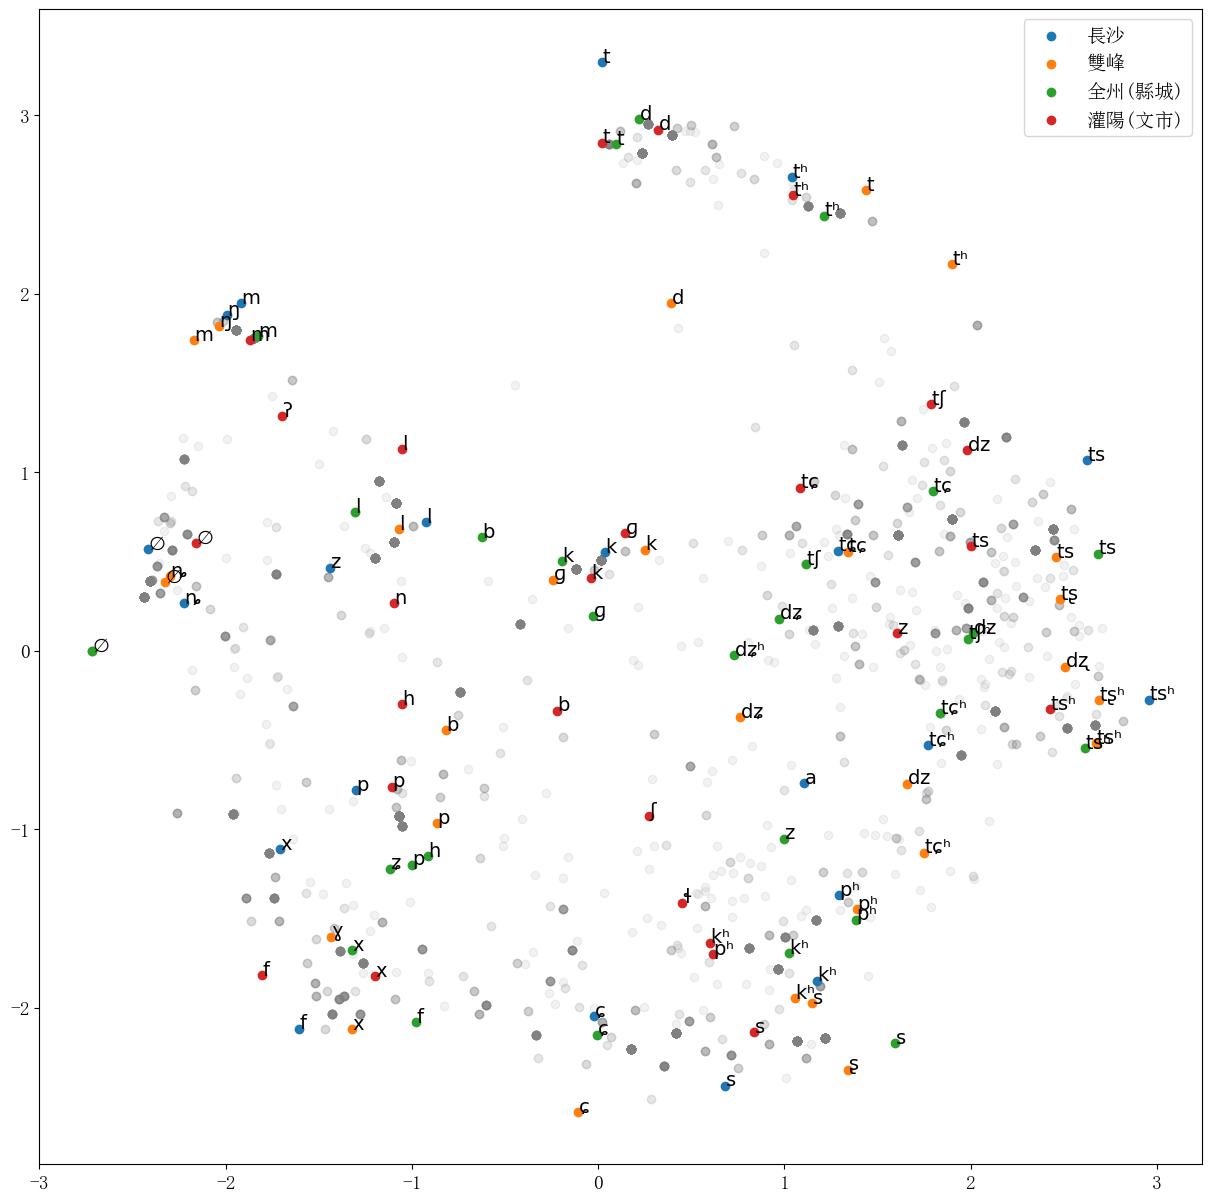

In [9]:
pca = PCA(2)
pc = pca.fit_transform(initial_emb)
emb_pc = pca.transform(dae.embedding.numpy())

plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(15, 15))

plt.scatter(pc[:, 0], pc[:, 1], color='gray', alpha=0.1)

for i, col in enumerate(data.loc[:, 'initial'].columns):
    plt.scatter(emb_pc[limits[i]:limits[i + 1], 0], emb_pc[limits[i]:limits[i + 1], 1], label=location.loc[col, '方言點'])
    for j, c in enumerate(data.dtypes['initial'][i].categories):
        plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(emb_pc[bases[i] + j, 0], emb_pc[bases[i] + j, 1]))

plt.legend()

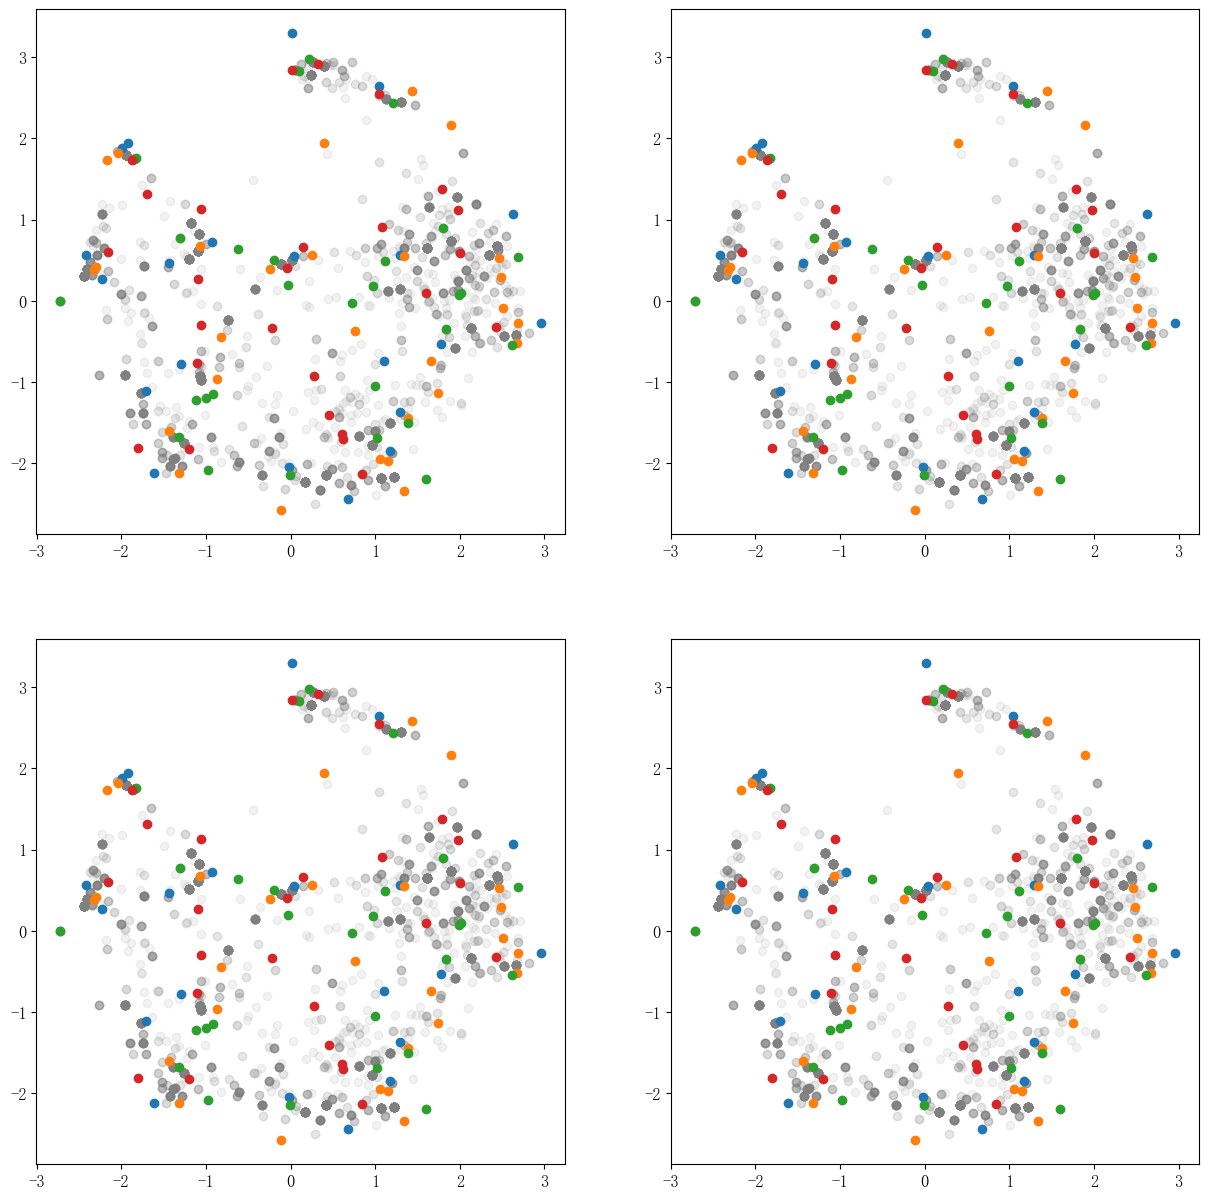

In [10]:
plt.rcParams['font.size'] = 12

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
axes = (ax1, ax2, ax3, ax4)

for i in range(4):
    pca = PCA(2)
    pc = pca.fit_transform(initial_emb)
    emb_pc = pca.transform(dae.embedding.numpy())
    axes[i].scatter(pc[:, 0], pc[:, 1], color='gray', alpha=0.1)

    for j, col in enumerate(data.loc[:, 'initial'].columns):
        axes[i].scatter(emb_pc[limits[j]:limits[j + 1], 0], emb_pc[limits[j]:limits[j + 1], 1], label=location.loc[col, '方言點'])

C:\Users\lerna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\lerna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


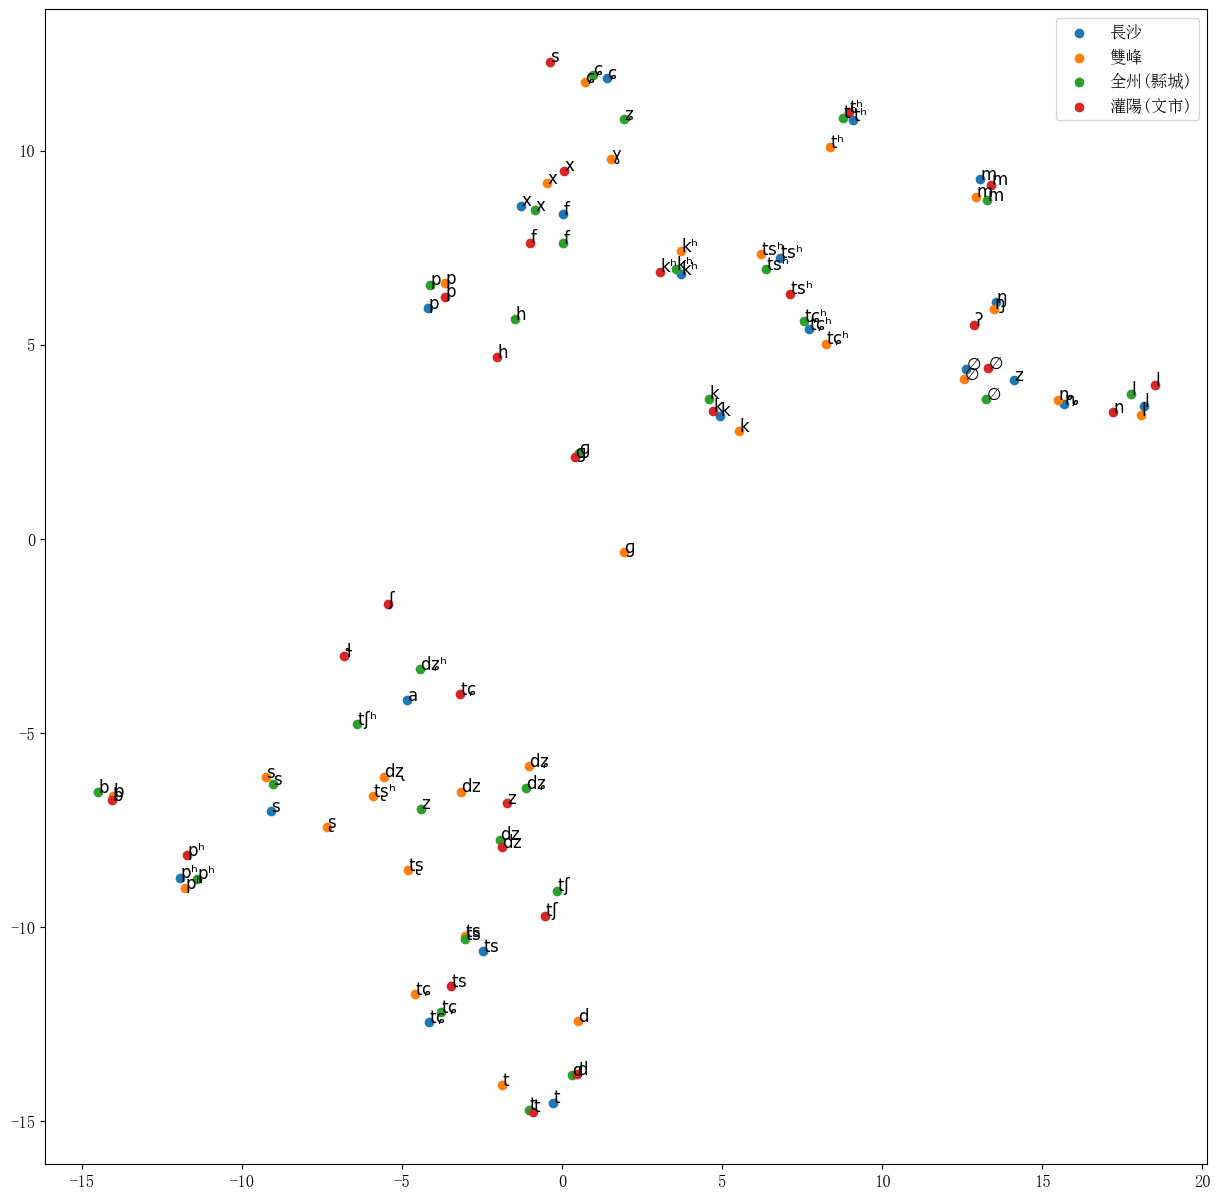

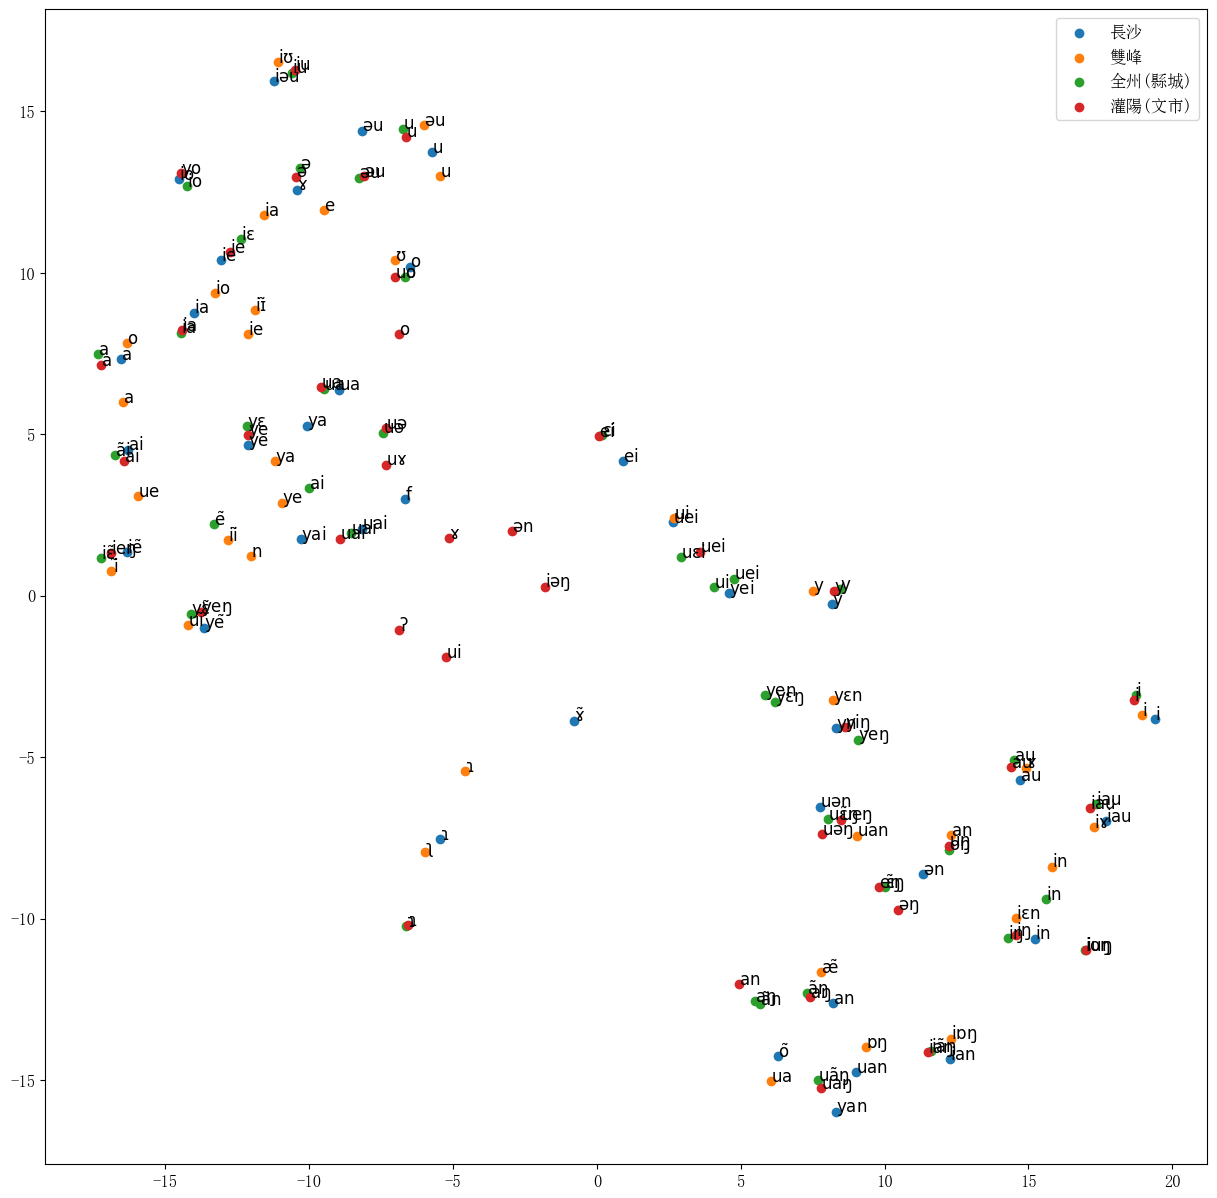

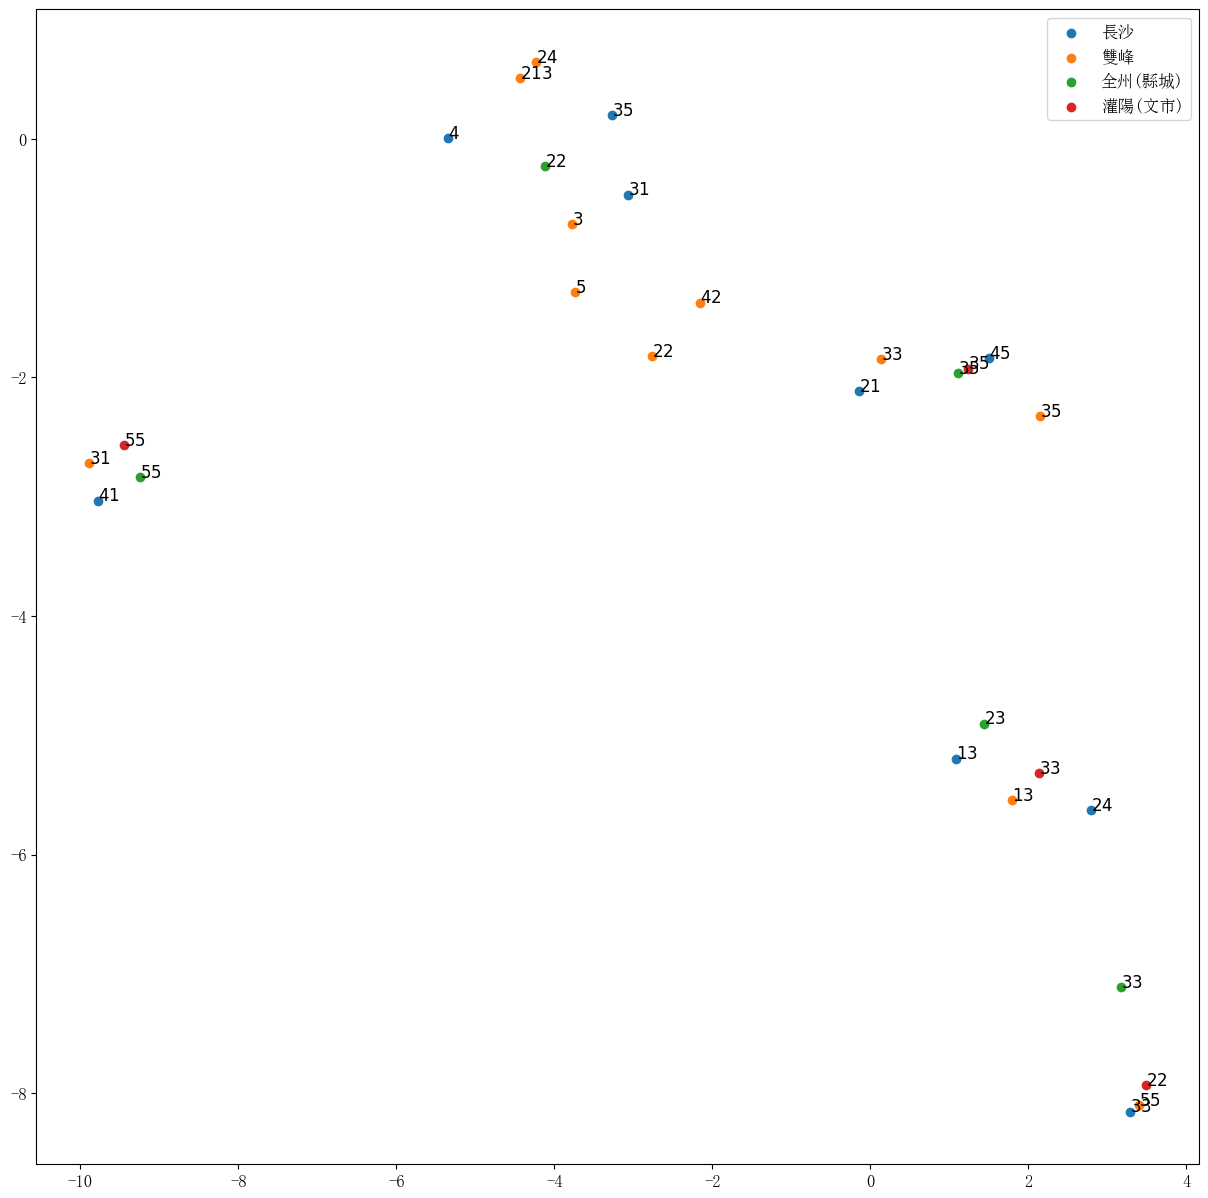

In [11]:
emb_tsne = TSNE(2).fit_transform(dae.embedding.numpy())

plt.rcParams['font.size'] = 12

for i, name in enumerate(('initial', 'final', 'tone')):
    fig = plt.figure(figsize=(15, 15))

    for j, col in enumerate(data.loc[:, name].columns):
        plt.scatter(
            emb_tsne[limits[i * 4 + j]:limits[i * 4 + j + 1], 0],
            emb_tsne[limits[i * 4 + j]:limits[i * 4 + j + 1], 1],
            label=location.loc[col, '方言點']
        )
        for k, c in enumerate(data.dtypes[name, col].categories):
            plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(emb_tsne[bases[i * 4 + j] + k, 0], emb_tsne[bases[i * 4 + j] + k, 1]))
    
    plt.legend()

C:\Users\lerna\AppData\Local\Temp\ipykernel_1688\4116485015.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\lerna\AppData\Local\Temp\ipykernel_1688\4116485015.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\lerna\AppData\Local\Temp\ipykernel_1688\4116485015.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


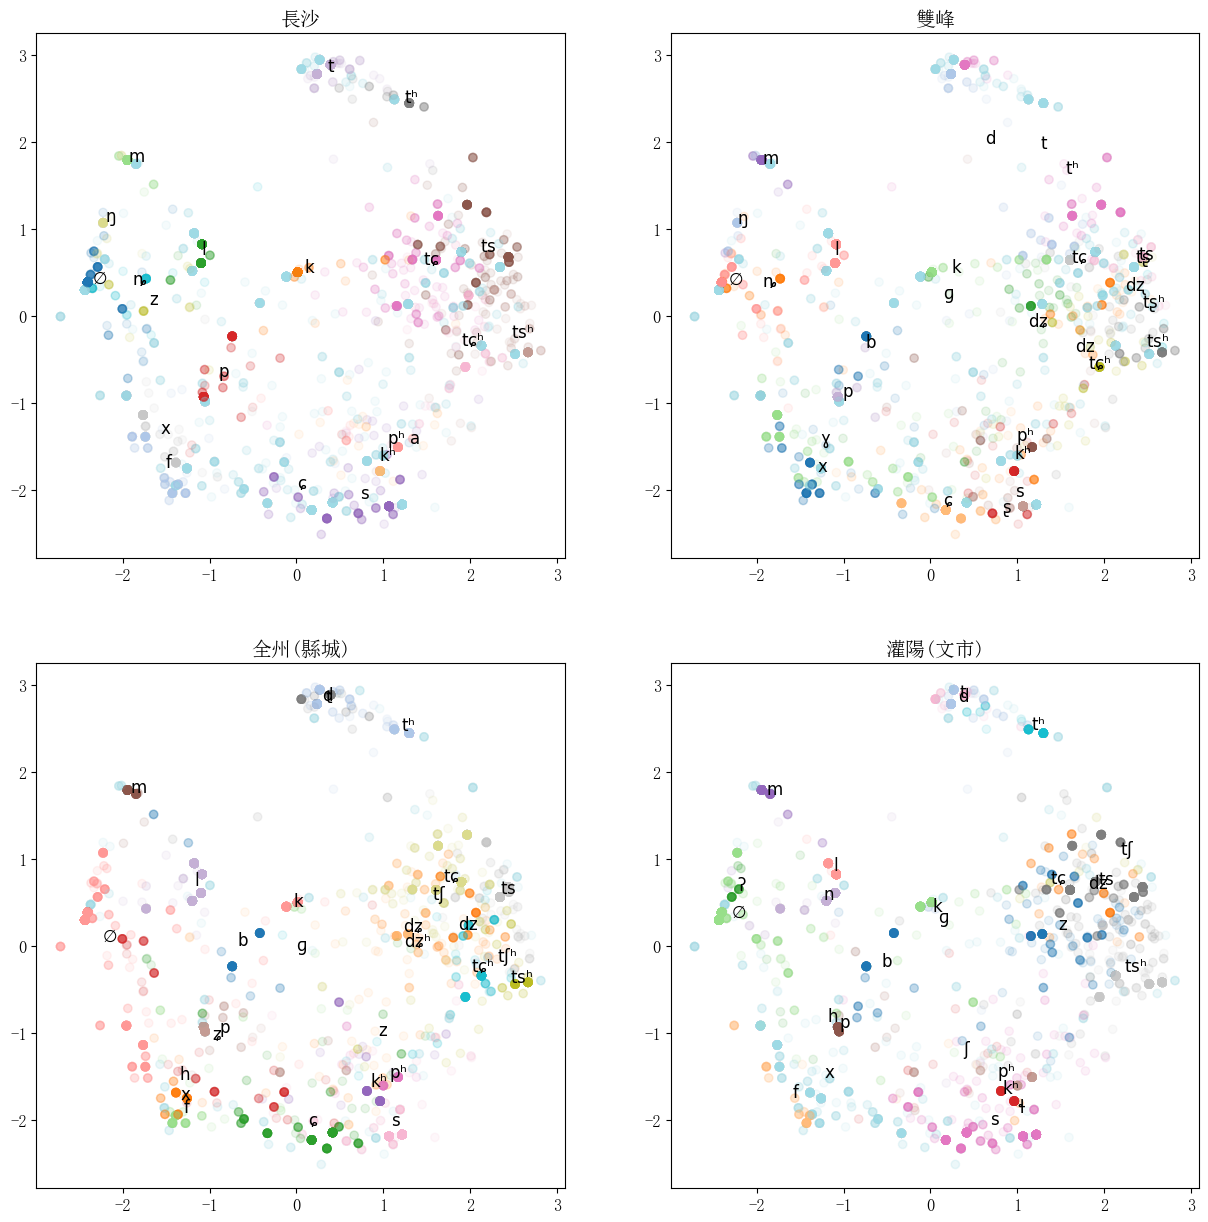

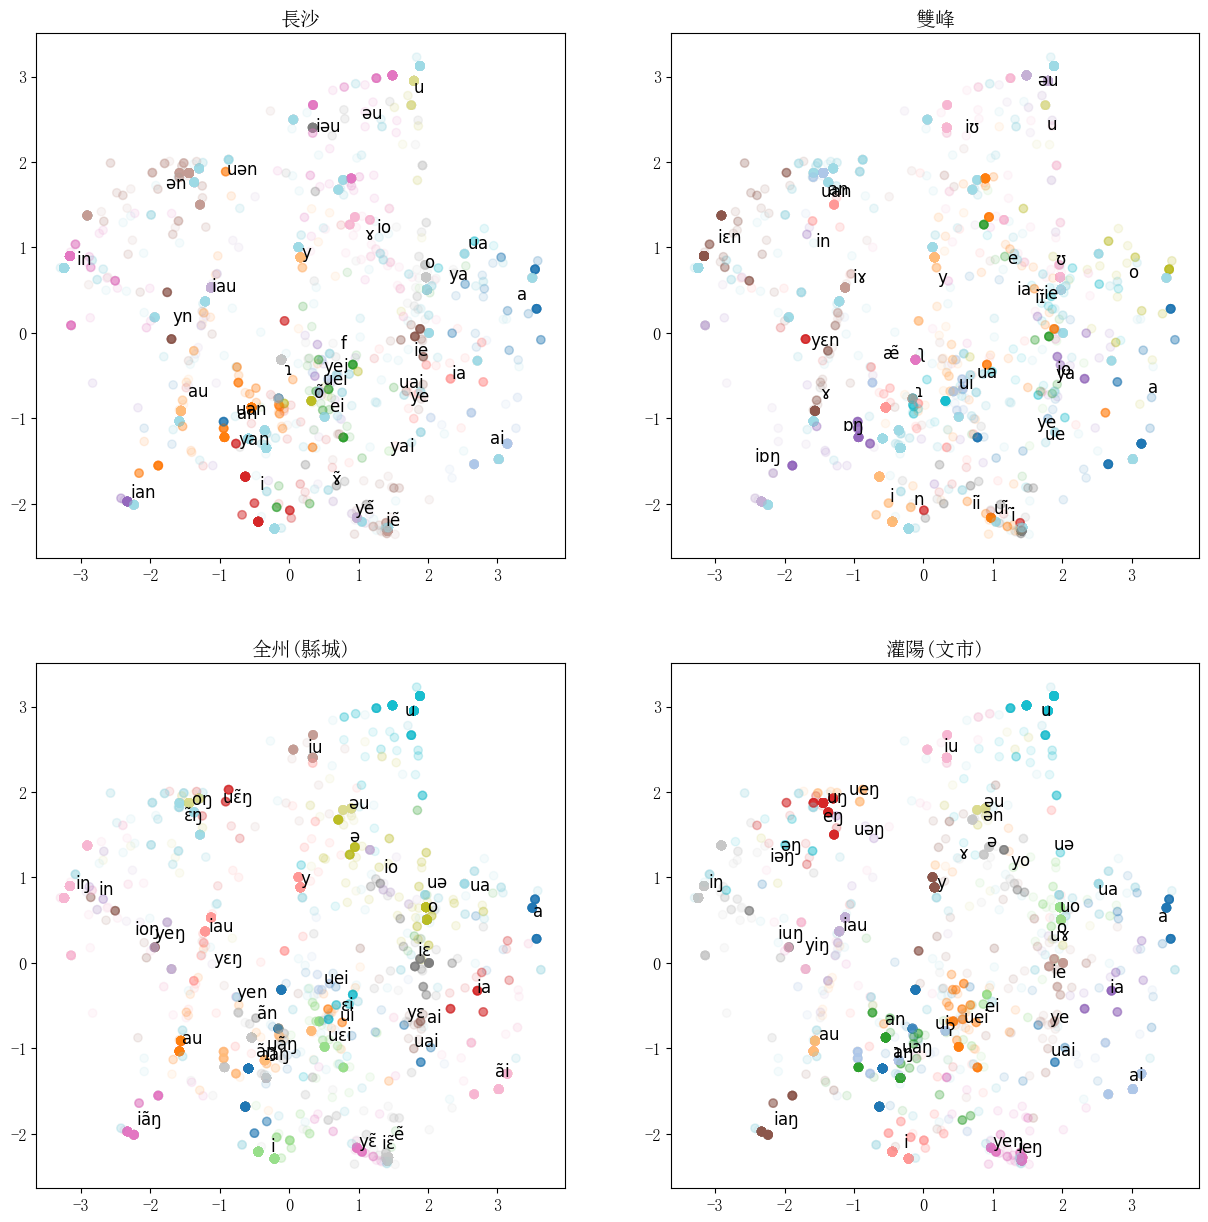

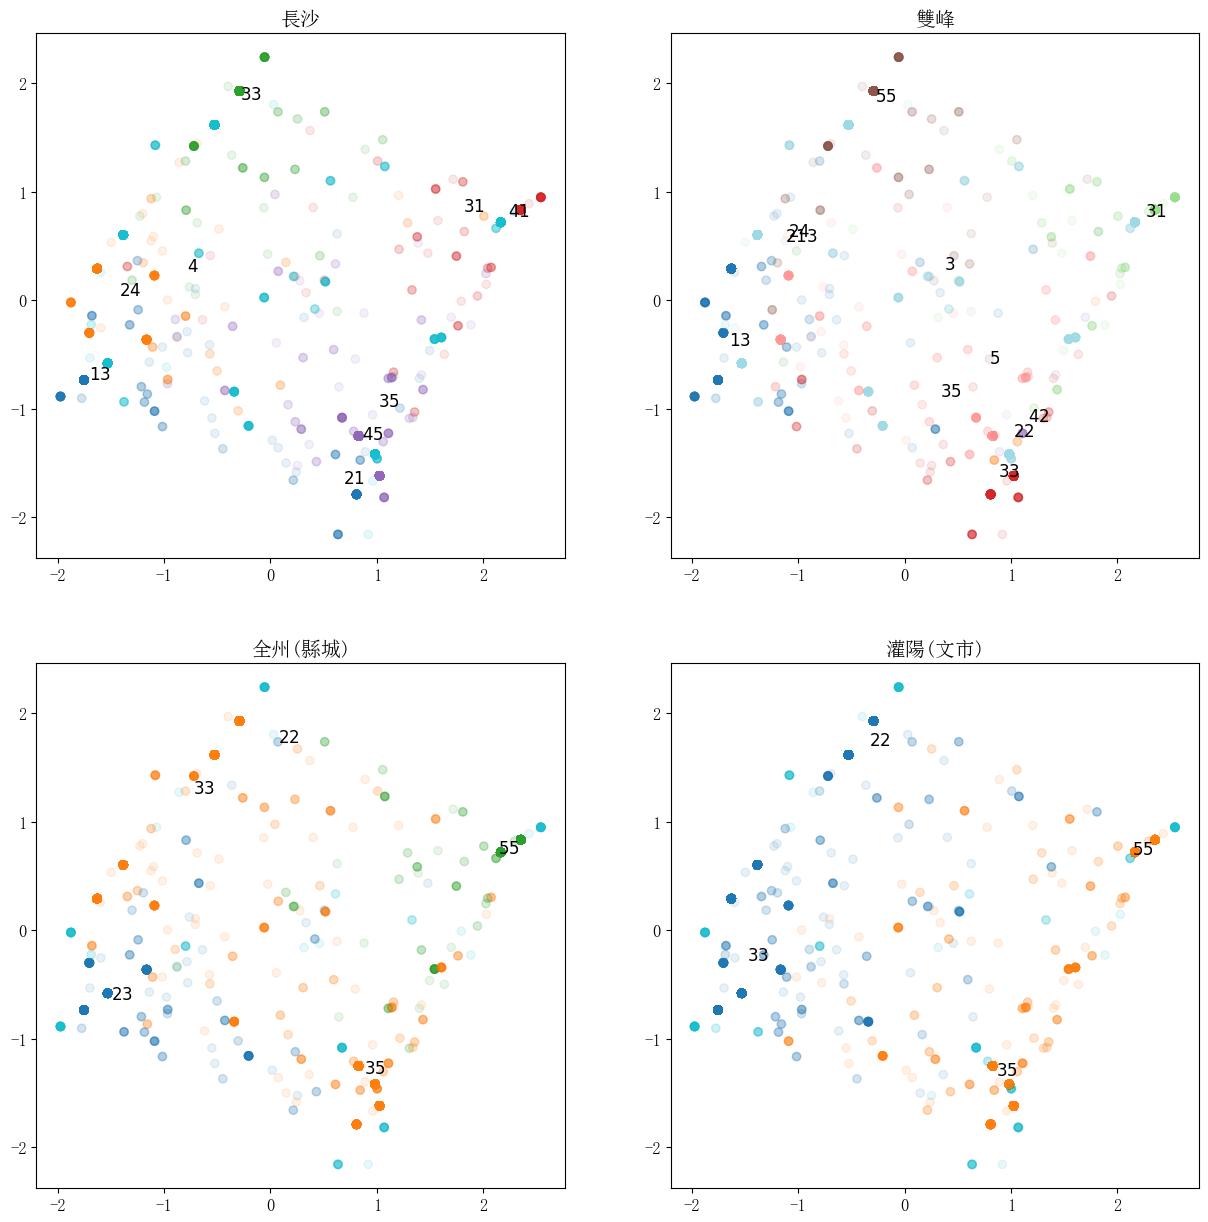

In [12]:
plt.rcParams['font.size'] = 12

for name, emb in (('initial', initial_emb), ('final', final_emb), ('tone', tone_emb)):
    pc = PCA(2).fit_transform(emb)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    axes = (ax1, ax2, ax3, ax4)

    for i, col in enumerate(data.loc[:, name].columns):
        axes[i].set_title(location.loc[col, '方言點'])
        axes[i].scatter(
            pc[:, 0],
            pc[:, 1],
            c=data.loc[:, (name, col)].cat.codes % 20,
            alpha=0.1,
            cmap='tab10' if len(data.dtypes[name, col].categories) <= 10 else 'tab20'
        )
        
        for c in data.dtypes[name, col].categories:
            points = pc[data.loc[:, (name, col)] == c]
            axes[i].annotate(r'$\mathrm{{{}}}$'.format(c), xy=(np.mean(points, axis=0)[0], np.mean(points, axis=0)[1]))
            
    fig.show()

C:\Users\lerna\AppData\Local\Temp\ipykernel_1688\2697716639.py:18: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  plt.imshow(filters.gaussian_filter(ret[0], sigma=1), extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]))
C:\Users\lerna\AppData\Local\Temp\ipykernel_1688\2697716639.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


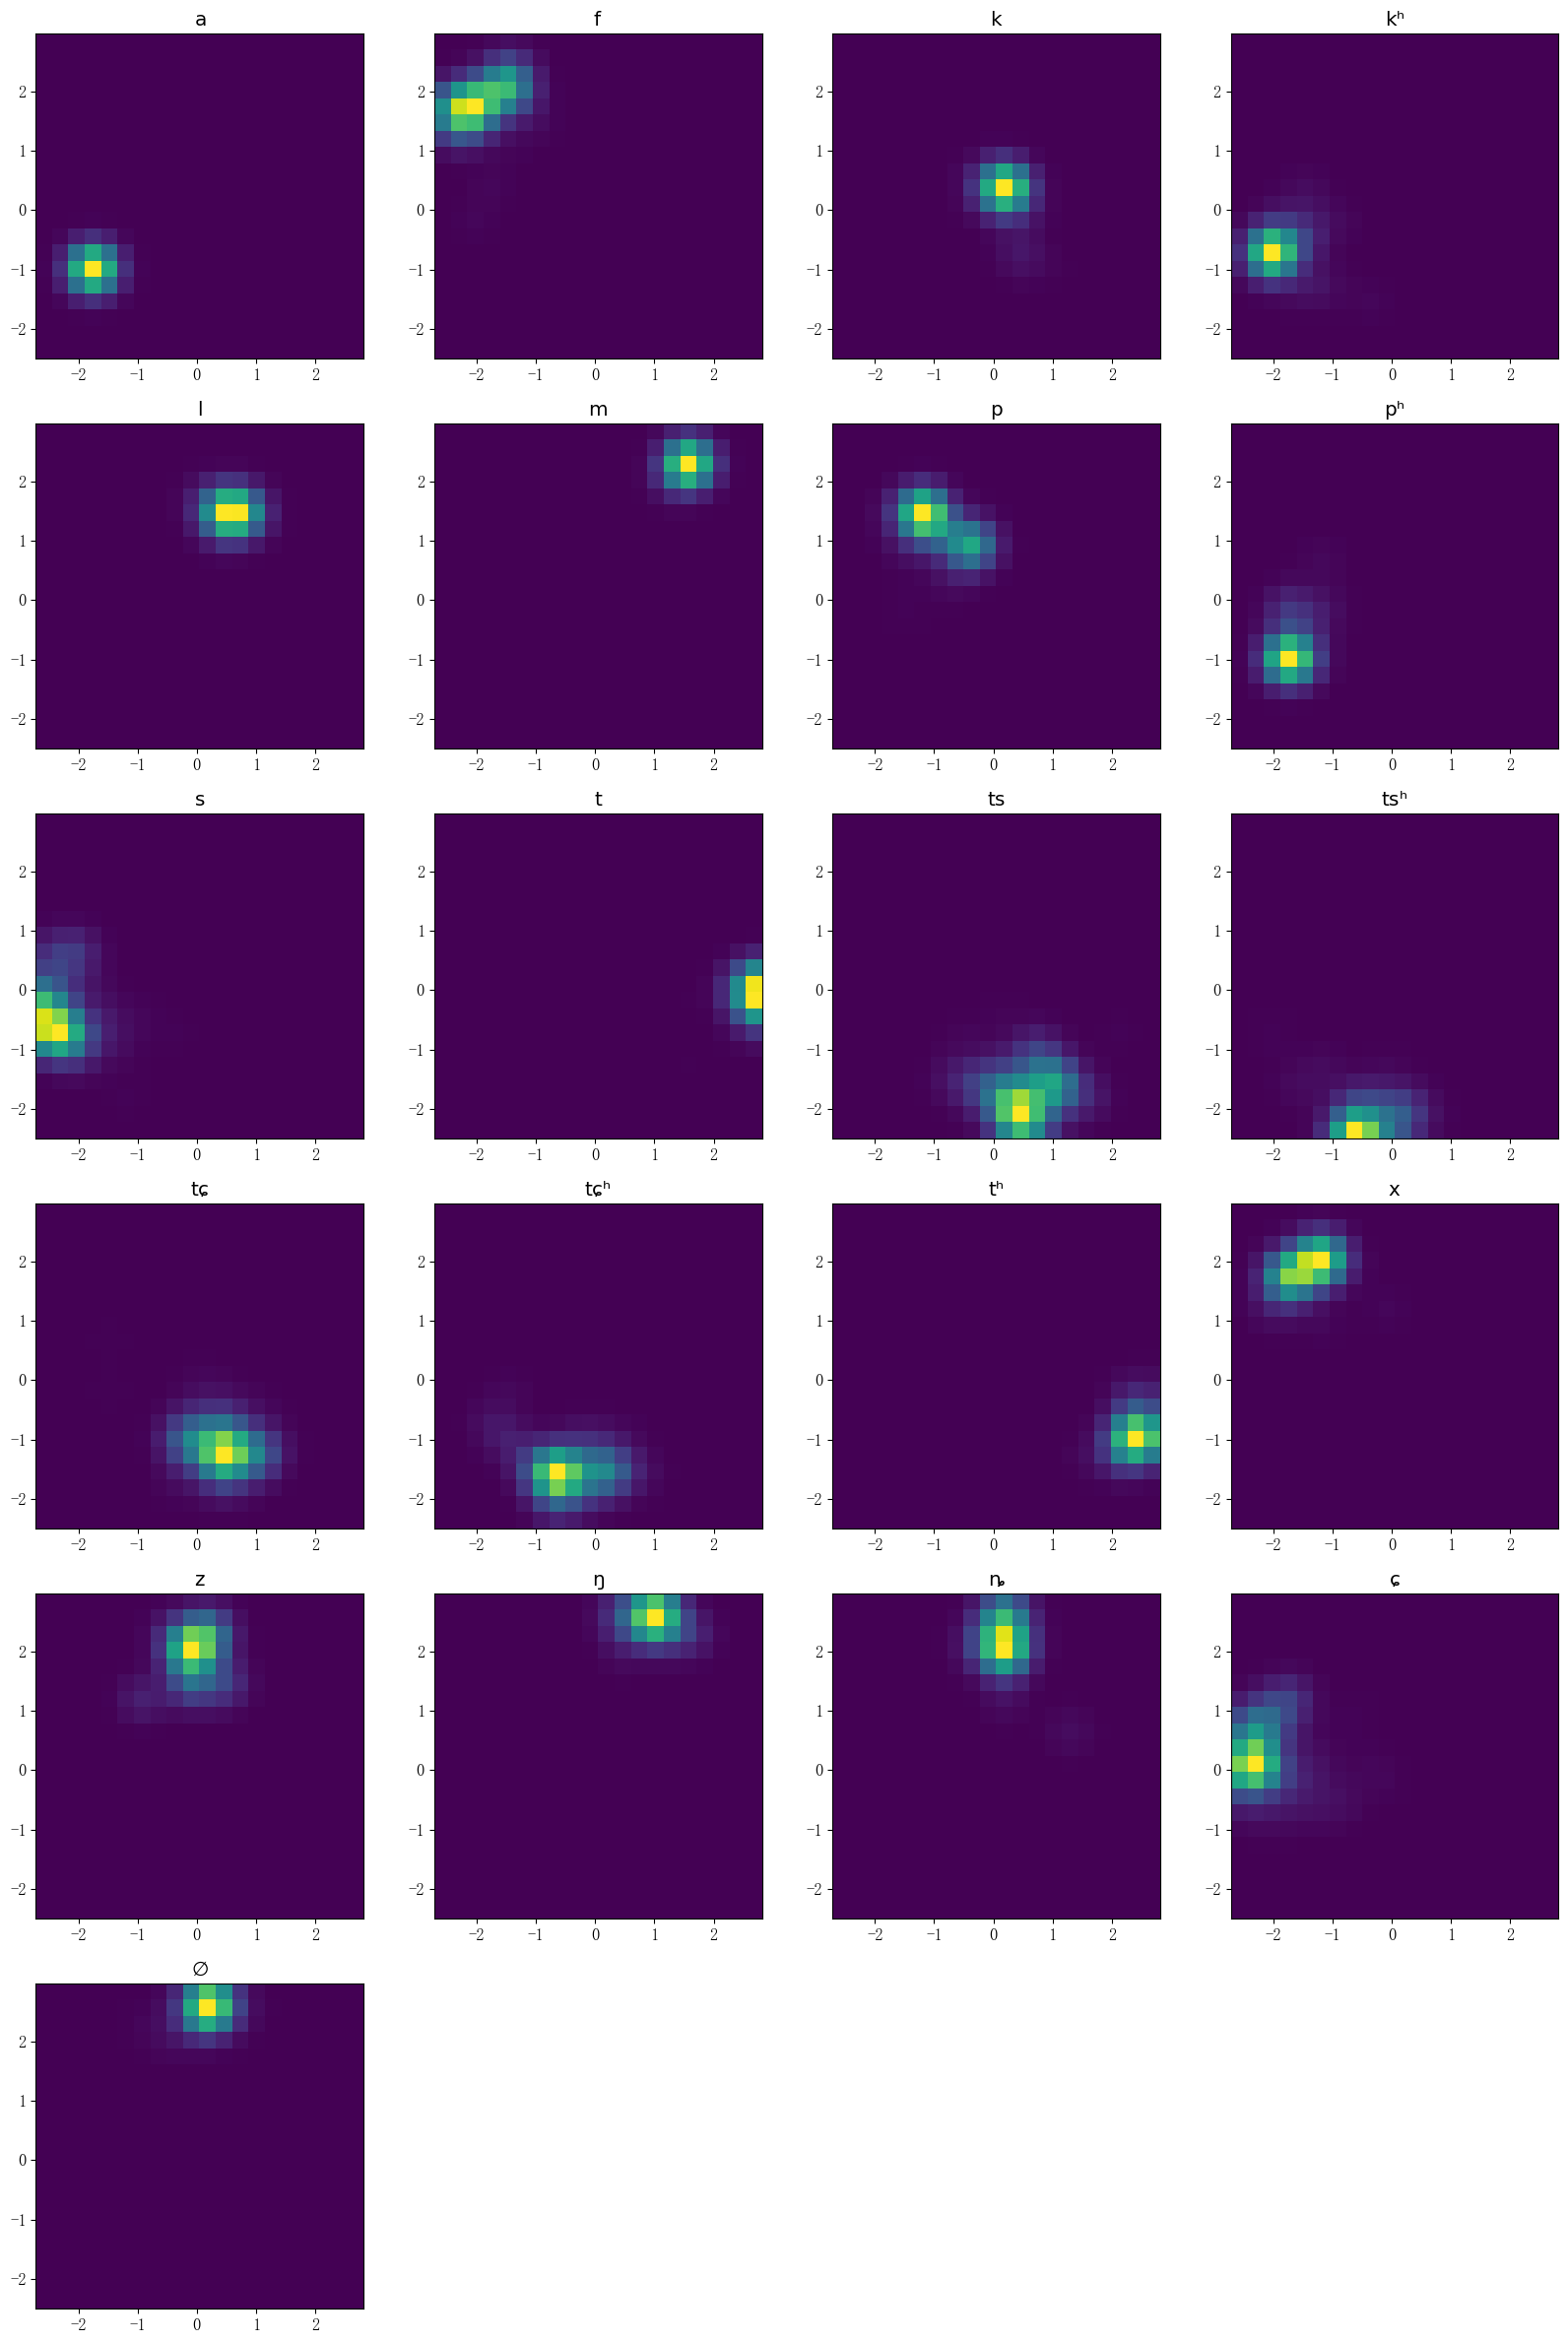

In [13]:
pc = PCA(2).fit_transform(initial_emb)
pc_min = np.min(pc, axis=0)
pc_max = np.max(pc, axis=0)

changsha_initials = data.dtypes['initial', '215'].categories

plt.rcParams['font.size'] = 12
cols = 4
rows = (len(changsha_initials) + cols - 1) // cols
fig = plt.figure(figsize=(20, rows * 5))

h, xbins, ybins = np.histogram2d(pc[:, 0], pc[:, 1], bins=[20, 20])

for i in range(len(changsha_initials)):
    mask = data.loc[:, ('initial', '215')] == changsha_initials[i]
    ret = np.histogram2d(pc[mask, 0], pc[mask, 1], bins=[xbins, ybins])
    plt.subplot(rows, cols, i + 1)
    plt.imshow(filters.gaussian_filter(ret[0], sigma=1), extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]))
    plt.title(r'$\mathrm{{{}}}$'.format(changsha_initials[i]))
    
fig.show()

C:\Users\lerna\AppData\Local\Temp\ipykernel_1688\2324525325.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\lerna\AppData\Local\Temp\ipykernel_1688\2324525325.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


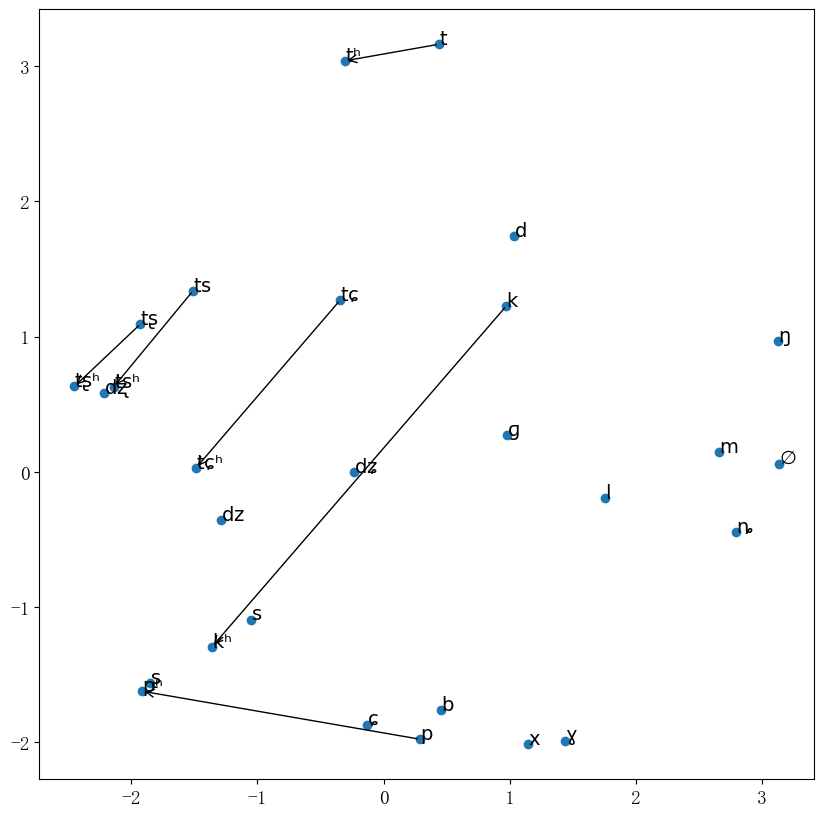

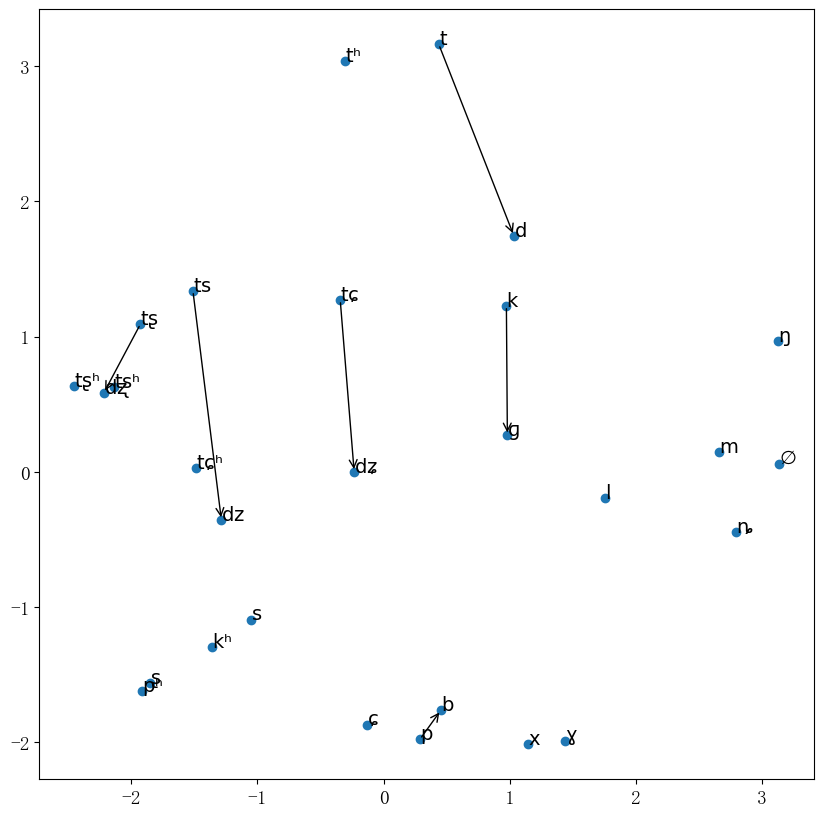

In [14]:
plt.rcParams['font.size'] = 14

col = data.loc[:, 'initial'].columns.get_loc('216')

pc = PCA(2).fit_transform(dae.embedding.numpy()[limits[col]:limits[col + 1]])

fig = plt.figure(figsize=(10, 10))
plt.scatter(pc[:, 0], pc[:, 1])

for i, c in enumerate(data.dtypes[col].categories):
    plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(pc[i, 0], pc[i, 1]))
    
dic = dict((c, i) for i, c in enumerate(data.dtypes[col].categories))
for group in (
    ('p', 'pʰ'),
    ('t', 'tʰ'),
    ('k', 'kʰ'),
    ('ts', 'tsʰ'),
    ('tʂ', 'tʂʰ'),
    ('tɕ', 'tɕʰ')
):
    idx = np.asarray([dic[c] for c in group])
    plt.annotate('', xytext=(pc[dic[group[0]], 0], pc[dic[group[0]], 1]), xy=(pc[dic[group[1]], 0], pc[dic[group[1]], 1]), arrowprops={'arrowstyle': '->'})
    
fig = plt.figure(figsize=(10, 10))
plt.scatter(pc[:, 0], pc[:, 1])

for i, c in enumerate(data.dtypes[col].categories):
    plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(pc[i, 0], pc[i, 1]))
    
fig.show()
    
dic = dict((c, i) for i, c in enumerate(data.dtypes[col].categories))
for group in (
    ('p', 'b'),
    ('t', 'd'),
    ('k', 'ɡ'),
    ('ts', 'dz'),
    ('tʂ', 'dʐ'),
    ('tɕ', 'dʑ')
):
    idx = np.asarray([dic[c] for c in group])
    plt.annotate('', xytext=(pc[dic[group[0]], 0], pc[dic[group[0]], 1]), xy=(pc[dic[group[1]], 0], pc[dic[group[1]], 1]), arrowprops={'arrowstyle': '->'})
    
fig.show()

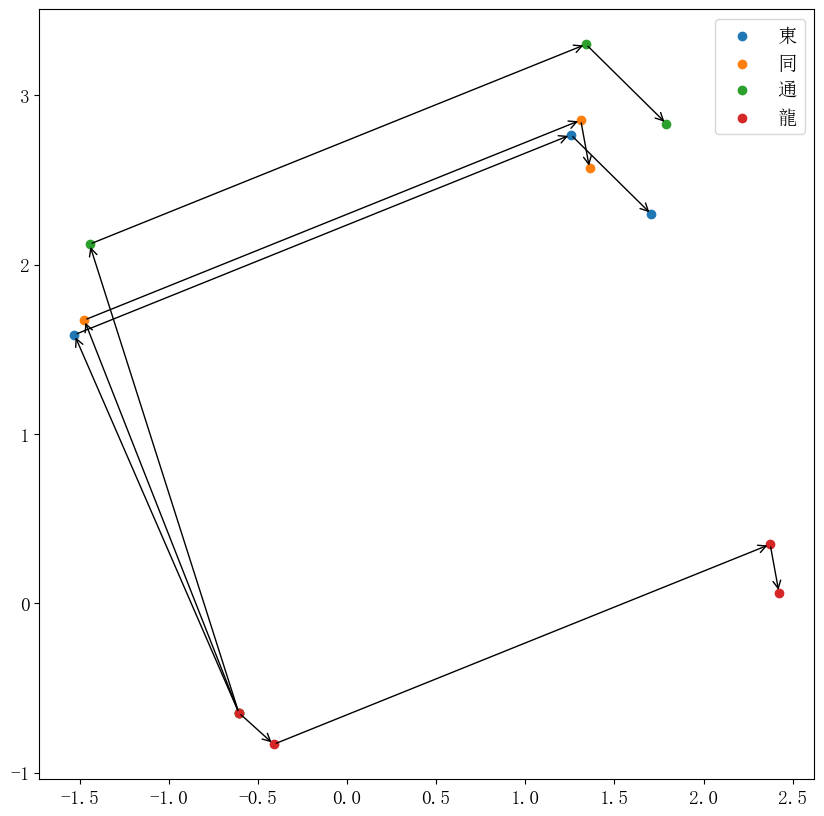

In [15]:
mask = char['character'].isin(('東', '通', '同', '龍'))

embs = np.stack(
    [np.zeros_like(initial_emb[mask]), initial_emb[mask], final_emb[mask], tone_emb[mask]],
    axis=1
)

points = np.cumsum(embs, axis=1)

pca = PCA(2)
pca.fit(np.reshape(embs, (-1, embs.shape[-1])))

plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(10, 10))

for i in range(embs.shape[0]):
    pc = pca.transform(np.cumsum(embs[i], axis=0))
    plt.scatter(pc[:, 0], pc[:, 1], label=char.loc[mask, 'character'].iloc[i])
    for j in range(pc.shape[0] - 1):
        plt.annotate('', xytext=(pc[j, 0], pc[j, 1]), xy=(pc[j + 1, 0], pc[j + 1, 1]), arrowprops={'arrowstyle': '->'})
    
plt.legend()

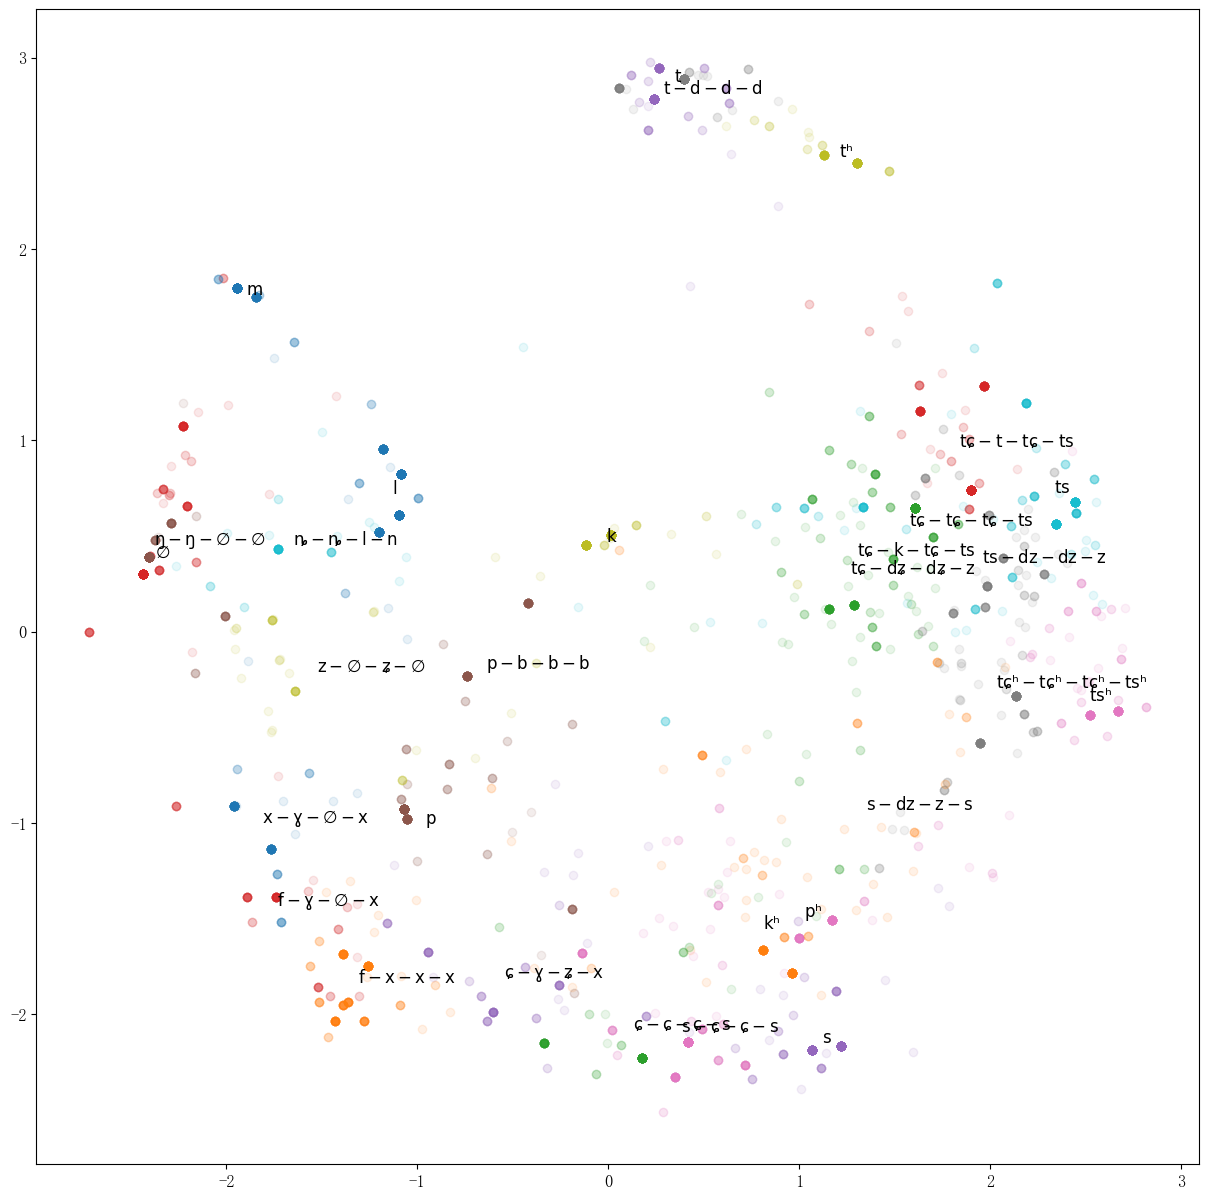

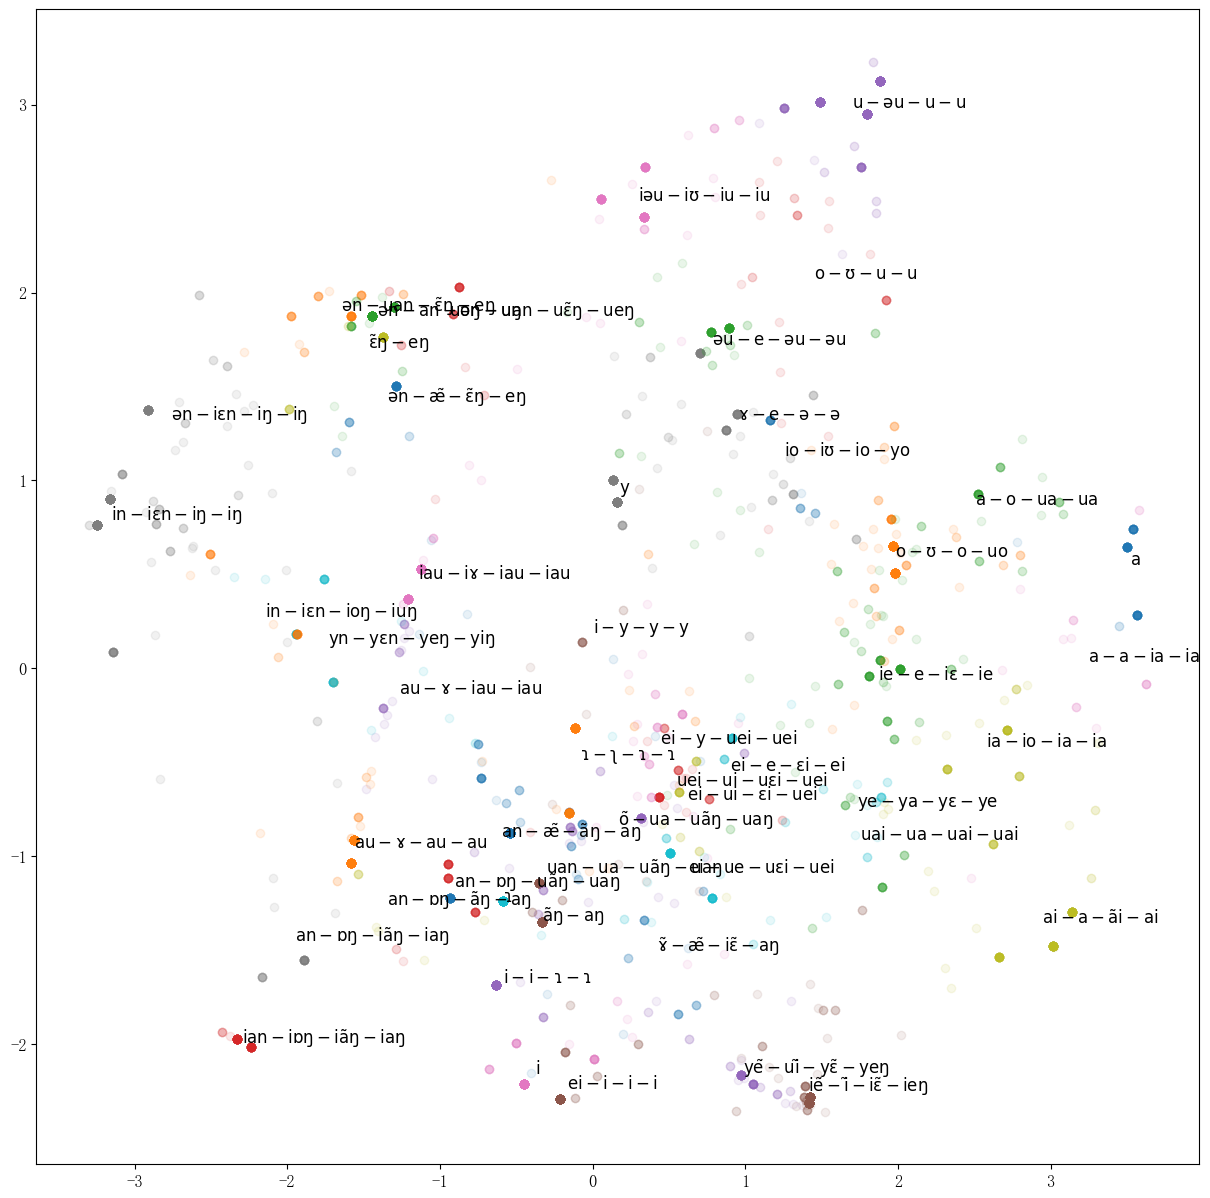

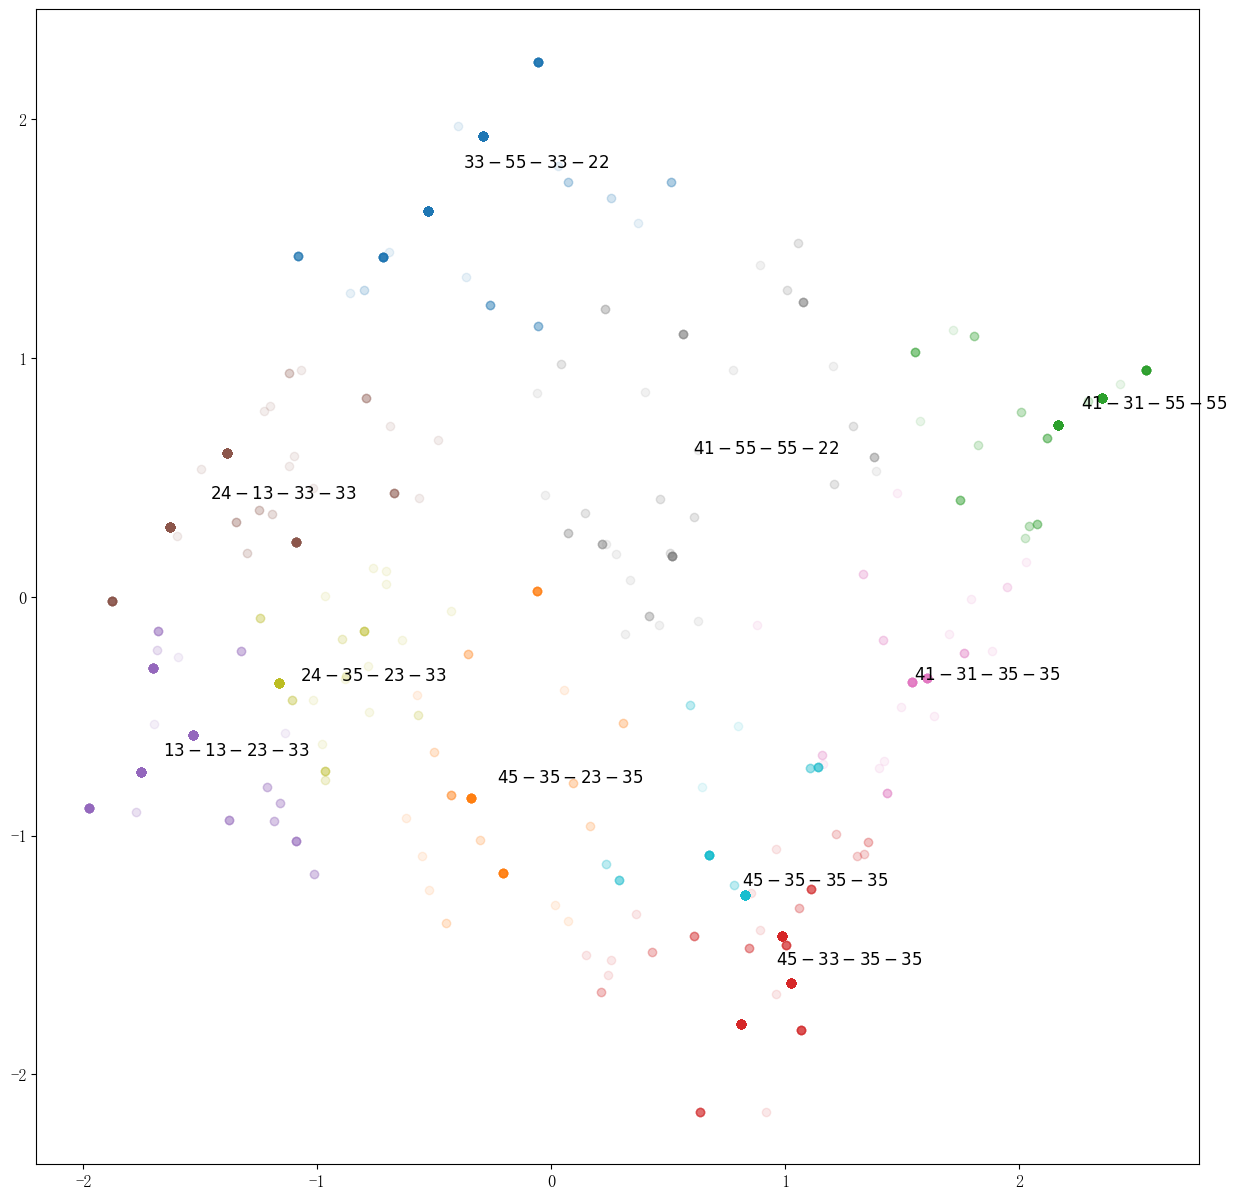

In [16]:
plt.rcParams['font.size'] = 12

for name, emb, clusters in (('initial', initial_emb, 30), ('final', final_emb, 50), ('tone', tone_emb, 10)):
    pca = PCA(2)
    pc = pca.fit_transform(emb)
    km = KMeans(n_clusters=clusters)
    km.fit(emb)
    center_pc = pca.transform(km.cluster_centers_)

    fit = plt.figure(figsize=(15, 15))
    for i in range(km.cluster_centers_.shape[0]):
        labels = data.loc[km.labels_ == i, name].mode().iloc[0]
        labels = labels[labels.notna()]
        if len(set(labels)) == 1:
            label = str(labels.iloc[0])
        else:
            label = '-'.join(str(l) for l in labels)
        plt.scatter(pc[km.labels_ == i, 0], pc[km.labels_ == i, 1], alpha=0.1)
        plt.annotate(r'$\mathrm{{{}}}$'.format(label), xy=(center_pc[i, 0], center_pc[i, 1]))

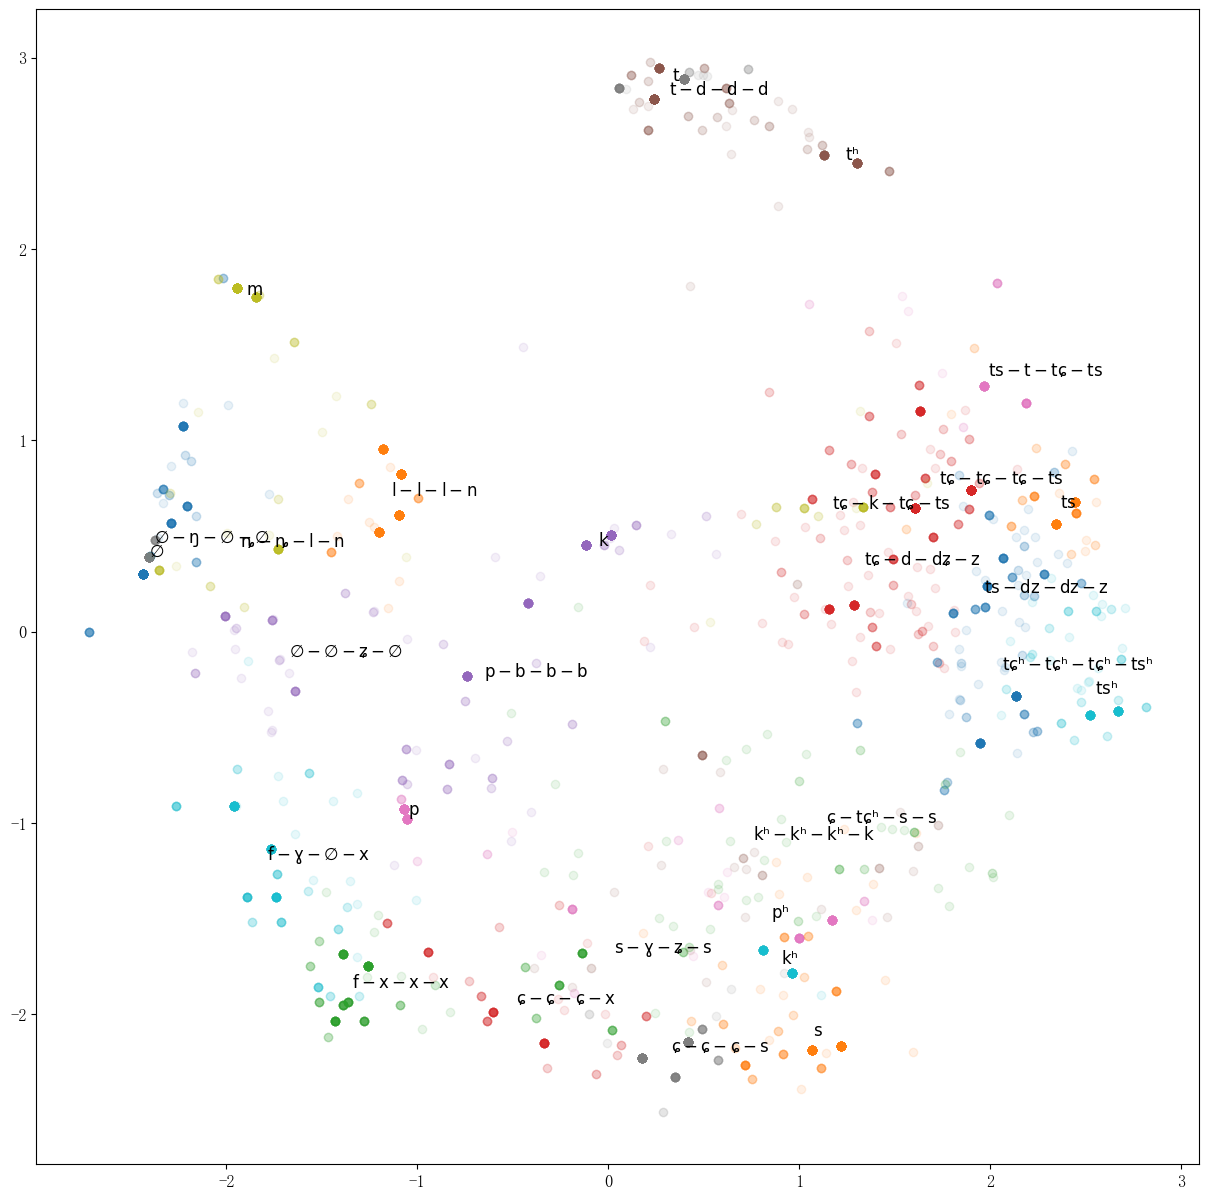

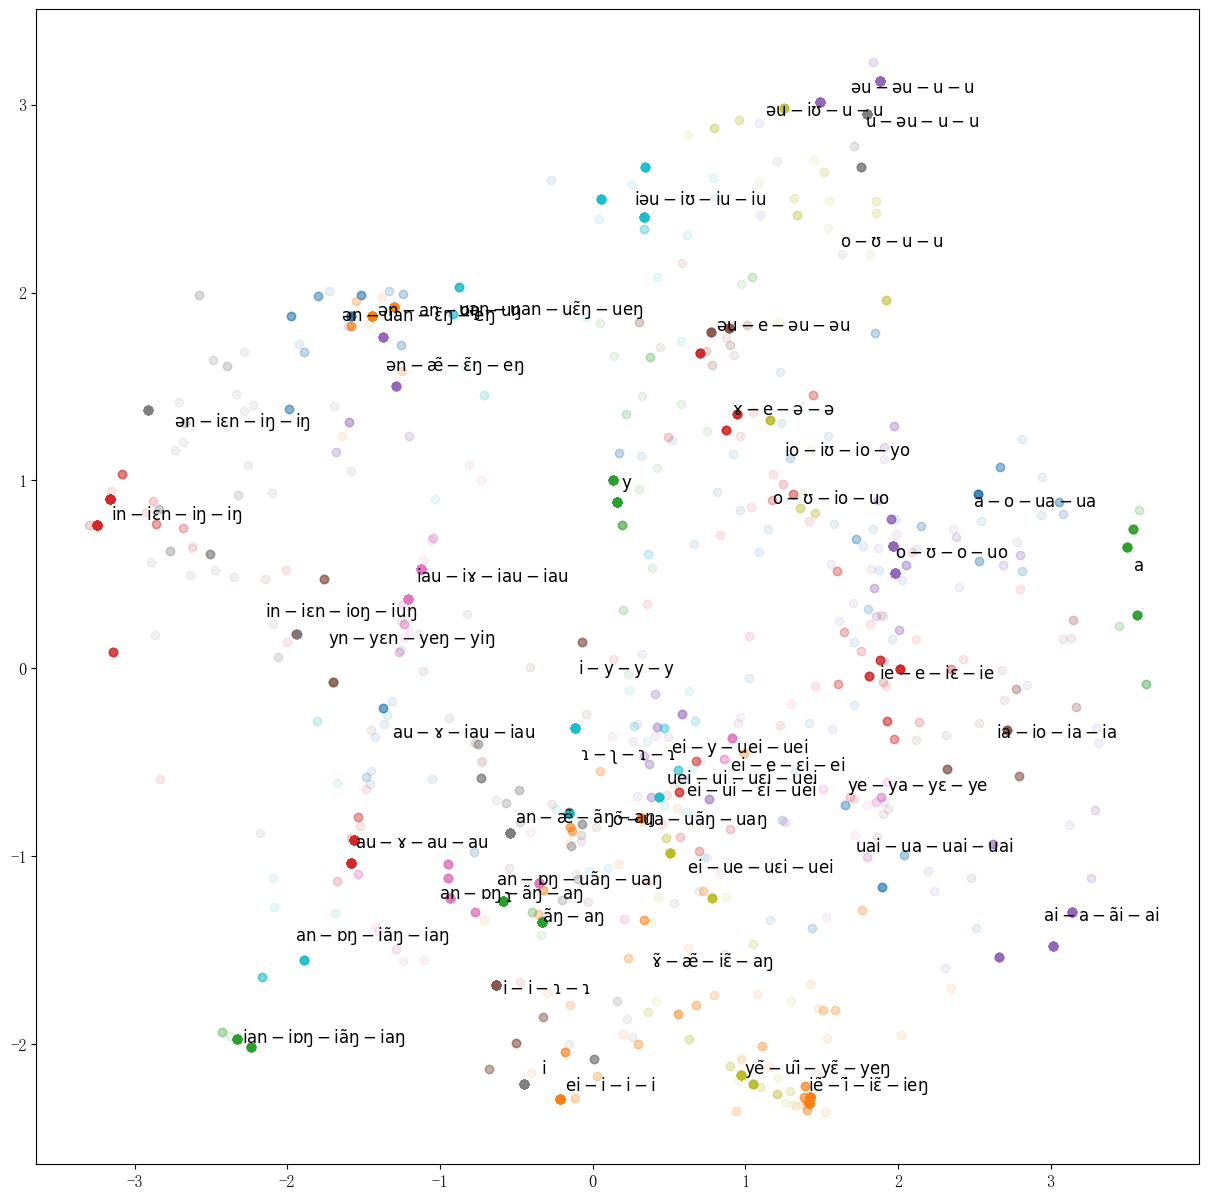

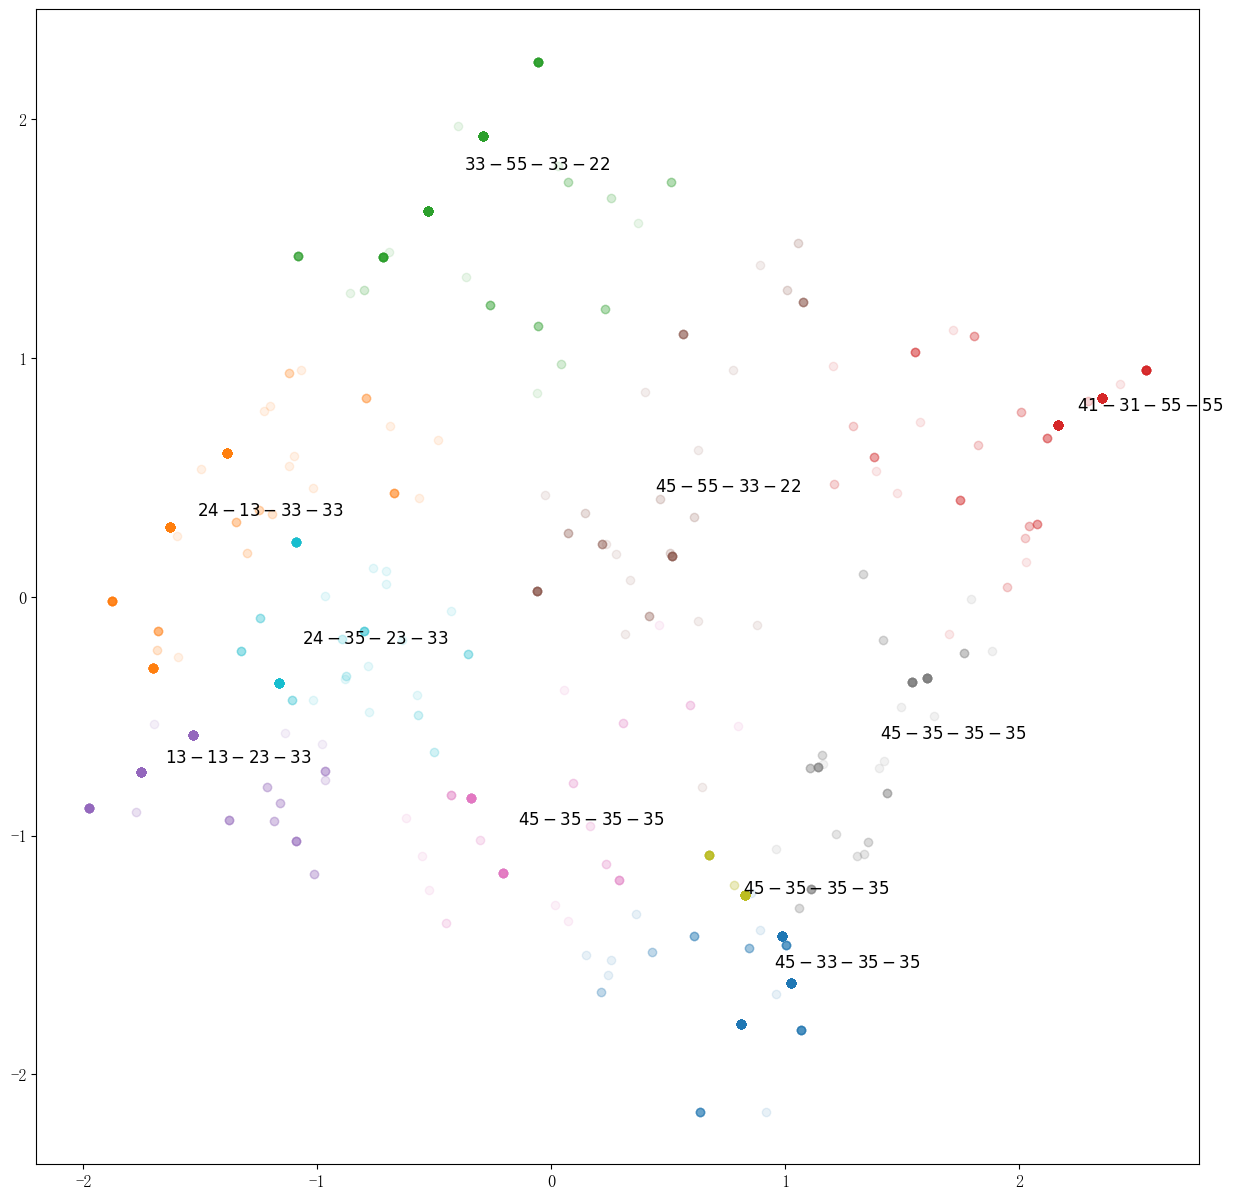

In [17]:
plt.rcParams['font.size'] = 12

for name, emb, clusters in (('initial', initial_emb, 30), ('final', final_emb, 50), ('tone', tone_emb, 10)):
    pca = PCA(2)
    pc = pca.fit_transform(emb)
    ac = AgglomerativeClustering(n_clusters=clusters)
    ac.fit(emb)

    fit = plt.figure(figsize=(15, 15))
    for i in range(ac.n_clusters_):
        labels = data.loc[ac.labels_ == i, name].mode().iloc[0]
        labels = labels[labels.notna()]
        if len(set(labels)) == 1:
            label = str(labels.iloc[0])
        else:
            label = '-'.join(str(l) for l in labels)
        plt.scatter(pc[ac.labels_ == i, 0], pc[ac.labels_ == i, 1], alpha=0.1)
        plt.annotate(r'$\mathrm{{{}}}$'.format(label), xy=(np.mean(pc[ac.labels_ == i], axis=0)[0], np.mean(pc[ac.labels_ == i], axis=0)[1]))